In [ ]:
# TO DO:
# add batch_normalization layer

# try with flattened inputs ?

In [5]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
import keras.backend as K
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.model_selection import train_test_split
from glob import glob
import math
%matplotlib inline

In [6]:
import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [7]:
# import data
imagePatches = glob('datasets/breast-histopathology/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2251_y1951_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1951_y2201_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2001_y2151_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1901_y2751_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2201_y2001_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1501_y2651_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2201_y2701_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2051_y2001_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1701_y2701_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2401_y2701_class1.png


In [8]:
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [9]:
sampled_class0 = random.sample(class0, 78786)
sampled_class1 = random.sample(class1, 78786)
len(sampled_class0)

78786

In [10]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (50, 50), #was (70,70)
                        interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label]) 
    return img_arrays

In [11]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [12]:
combined_data = np.concatenate((class0_array, class1_array))
#random.seed(41)
#random.shuffle(combined_data)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [13]:
X = []
y = []

for features, label in combined_data:
    X.append(features)
    y.append(label)

In [14]:
X = np.array(X).reshape(-1, 50, 50, 3)
y = np.array(y)

print(X.shape)
print(y.shape)

(157572, 50, 50, 3)
(157572,)


In [15]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2,
                                    random_state = 11)

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, 
                            test_size = 0.25, random_state = 11) 
                            # 0.25 x 0.8 = 0.2
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)
val_y = to_categorical(val_y)
train_y_label = np.argmax(train_y, axis=1) # from one-hot encoding to integer
test_y_label = np.argmax(test_y, axis=1)
val_y_label = np.argmax(val_y, axis=1)
class_names = ('non-cancer','cancer')
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(94542, 50, 50, 3) (31515, 50, 50, 3) (94542, 2) (31515, 2)


In [16]:
print('Min value: ', train_x.min())
print('Max value: ', train_x.max())

Min value:  0
Max value:  255


In [17]:
train_x = train_x / 255
test_x = test_x / 255
print('Min value: ', train_x.min())
print('Max value: ', train_x.max())

Min value:  0.0
Max value:  1.0


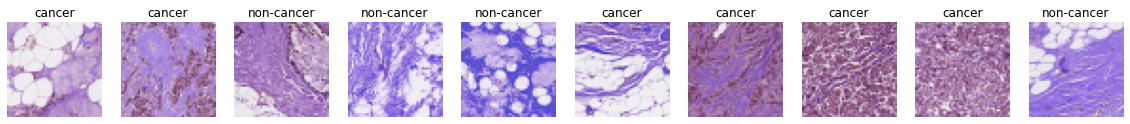

In [18]:
image_count = 10

_, axs = plt.subplots(1, image_count, figsize=(20, 20))
for i in range(image_count):
  random_idx=random.randint(0, train_x.shape[0])
  axs[i].imshow(train_x[random_idx], cmap='gray')
  axs[i].axis('off')
  axs[i].set_title(class_names[train_y_label[random_idx]])

In [19]:
np.where(train_x == train_x[0])

(array([    0,     0,     0, ..., 94541, 94541, 94541]),
 array([ 0,  0,  0, ..., 46, 47, 48]),
 array([ 0,  0,  0, ..., 10, 35, 41]),
 array([0, 1, 2, ..., 2, 2, 2]))

In [20]:
batch_size = 250
input_shape = (50, 50, 3)

num_features = 7500#50*50*3
latent_dim = 32

In [21]:
vae = keras.models.load_model('models/vae.h5')
encoder = keras.models.load_model('models/encoder.h5')
decoder = keras.models.load_model('models/decoder.h5')

2022-04-13 11:29:37.357906: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
ae = keras.models.load_model('models/ae.h5')
encoder = keras.models.load_model('models/ae_encoder.h5')
decoder = keras.models.load_model('models/ae_decoder.h5')

In [23]:
def loss_func(encoder_mu, encoder_log_variance):

    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = K.mean(K.square(y_true - y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * K.sum(1.0 + encoder_log_variance - K.square(encoder_mu) - K.exp(encoder_log_variance), axis=[1, 2, 3])
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * K.backend.sum(1.0 + encoder_log_variance - K.square(encoder_mu) - K.exp(encoder_log_variance), axis=[1, 2, 3])
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [24]:
beta_coefficient=1

#Information needed to compute the loss function
vae_input = vae.input
vae_output = vae.output
mu = encoder.get_layer('z_mean').output
log_var= encoder.get_layer('z_log_var').output

#vae.add_loss(loss_func(encoder, decoder, beta_coefficient))

vae.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), loss=loss_func(mu, log_var))

ValueError: No such layer: z_mean. Existing layers are [<keras.engine.input_layer.InputLayer object at 0x7fbad86748b0>, <keras.layers.convolutional.Conv2D object at 0x7fbad8674940>, <keras.layers.convolutional.Conv2D object at 0x7fbad8674f70>, <keras.layers.convolutional.Conv2D object at 0x7fbad86026d0>, <keras.layers.convolutional.Conv2D object at 0x7fbad8602be0>, <keras.layers.pooling.MaxPooling2D object at 0x7fbad8602ee0>, <keras.layers.convolutional.Conv2D object at 0x7fbad8604310>, <keras.layers.convolutional.Conv2D object at 0x7fbad86048b0>, <keras.layers.convolutional.Conv2D object at 0x7fbad8604dc0>].

In [25]:
model = ae
#model.compile( optimizer='adam')

In [ ]:
latent_dim = 256

In [28]:
epoch_count = 5
np.random.seed(42)
checkpoint_filepath = 'models/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_x, train_x, batch_size, epoch_count,
         validation_data = (test_x, test_x), callbacks=[early_stop] )

Epoch 1/5
379/379 [==============================] - 386s 1s/step - loss: 0.0052 - val_loss: 0.0051
Epoch 2/5
379/379 [==============================] - 384s 1s/step - loss: 0.0043 - val_loss: 0.0038
Epoch 3/5
379/379 [==============================] - 386s 1s/step - loss: 0.0039 - val_loss: 0.0041
Epoch 4/5
379/379 [==============================] - 387s 1s/step - loss: 0.0036 - val_loss: 0.0035
Epoch 5/5
379/379 [==============================] - 387s 1s/step - loss: 0.0033 - val_loss: 0.0029


In [29]:
def plot_history(history,metric=None):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_xlim([1,epoch_count])
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  ax1.set_xlabel('Epochs')
  _=ax1.legend(loc='lower left')

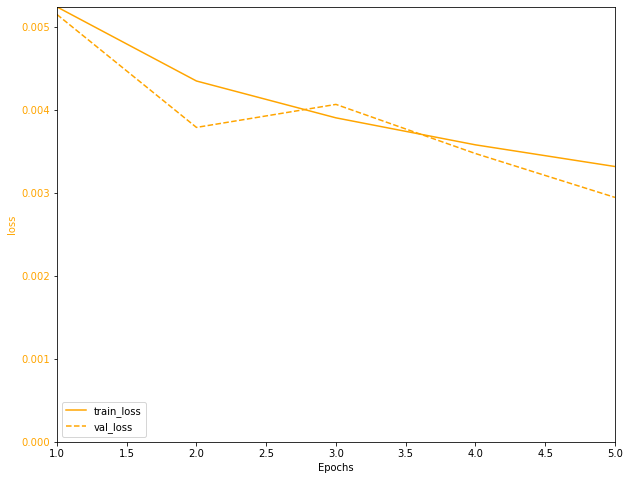

In [30]:
plot_history(history)

In [ ]:
train_x_latent = encoder.predict(train_x)
test_x_latent = encoder.predict(test_x)

In [ ]:
def plot_2d_data(data_2d,y,titles=None,figsize=(7,7)):
  _,axs=plt.subplots(1,len(data_2d),figsize=figsize)

  for i in range(len(data_2d)):
    if (titles!=None):
      axs[i].set_title(titles[i])
    scatter=axs[i].scatter(data_2d[i][:,0],data_2d[i][:,1],s=1,c=y[i],cmap=plt.cm.Paired)
    axs[i].legend(*scatter.legend_elements())

In [ ]:
plot_2d_data([train_x_latent[0],val_x_latent[0],test_x_latent[0]],[train_y_label,val_y_label,test_y_label],['Train','Validation','Test'],(18,6))

In [ ]:
# generate images
random_sample = np.array([[random.normalvariate(0,1), random.normalvariate(0,1)]])

print('Random sample: ',random_sample)

decoded_x = decoder.predict(random_sample)
digit = decoded_x[0].reshape(input_shape)

plt.axis('off')
plt.imshow(digit, cmap='gray')
plt.show()

In [ ]:
def plot_generated_images(generated_images, nrows, ncols,no_space_between_plots=False, figsize=(10, 10)):
  _, axs = plt.subplots(nrows, ncols,figsize=figsize,squeeze=False)

  for i in range(nrows):
    for j in range(ncols):
      axs[i,j].axis('off')
      axs[i,j].imshow(generated_images[i][j], cmap='gray')

  if no_space_between_plots:
    plt.subplots_adjust(wspace=0,hspace=0)

  plt.show()

In [ ]:
n = 20 # number of images per row and column
limit=3 # random values are sampled from the range [-limit,+limit]

grid_x = np.linspace(-limit,limit, n) 
grid_y = np.linspace(limit,-limit, n)

generated_images=[]
for i, yi in enumerate(grid_y):
  single_row_generated_images=[]
  for j, xi in enumerate(grid_x):
    random_sample = np.array([[xi, yi]])
    decoded_x = decoder.predict(random_sample)
    single_row_generated_images.append(decoded_x[0].reshape(input_shape))
  generated_images.append(single_row_generated_images)      

plot_generated_images(generated_images,n,n,True)

In [ ]:
# ae
n = 20 # number of images per row and column
limit=3 # random values are sampled from the range [-limit,+limit]

grid_x = np.linspace(-limit,limit, n) 
grid_y = np.linspace(limit,-limit, n)

generated_images=[]
for i, yi in enumerate(grid_y):
  single_row_generated_images=[]
  for j, xi in enumerate(grid_x):
    random_sample = np.array([[xi, yi]])
    decoded_x = decoder.predict(random_sample)
    single_row_generated_images.append(decoded_x[0].reshape(input_shape))
  generated_images.append(single_row_generated_images)      

plot_generated_images(generated_images,n,n,True)

In [ ]:
plt.imshow(train_x[0])
plt.show()

train_x[0].shape

print(train_y[0])
print(train_y_label[0])


In [31]:
p = model.predict(train_x)

In [ ]:
p[0].shape

In [34]:
ae.save_weights('weights/ae.h5')

In [ ]:
plt.imshow(p[1])
plt.show()

In [ ]:
plt.imshow(train_x[0])
plt.show()


In [32]:
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        ax[0][i].imshow(np.reshape(y_true[i], (50, 50, 3)), aspect='auto')
        ax[1][i].imshow(np.reshape(y_pred[i], (50, 50, 3)), aspect='auto')
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


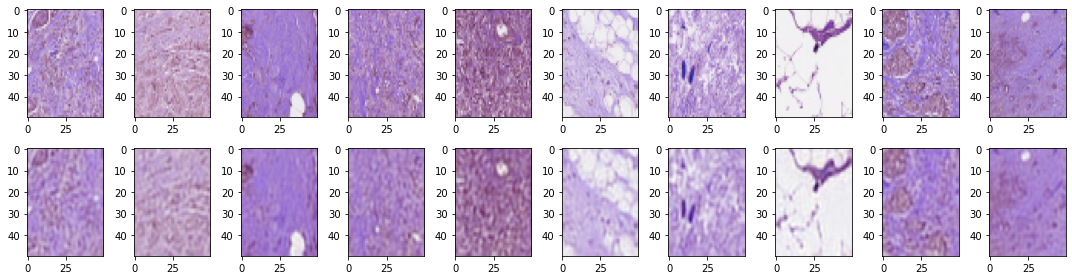

In [33]:
plot_predictions(train_x, p)

In [93]:
# Scatter with images instead of points
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
img_size = 50
def imscatter(x, y, ax, imageData, zoom):
    images = []
    for i in range(len(x)):
        x0, y0 = x[i], y[i]
        # Convert to image
        img = imageData[i]*255.
        img = img.astype(np.uint8).reshape([img_size,img_size,3])
        #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        # Note: OpenCV uses BGR and plt uses RGB
        image = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
        images.append(ax.add_artist(ab))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

In [104]:
#https://github.com/despoisj/LatentSpaceVisualization/blob/master/visuals.py
from sklearn import manifold

def computeTSNEProjectionOfLatentSpace(X, X_encoded, display=True):
    # Compute latent space representation
    print("Computing latent space projection...")
    #X_encoded = encoder.predict(X)

    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X_encoded)

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize=(15, 15))
        ax = fig.add_subplot(111, facecolor='black')
        imscatter(X_tsne[:, 0], X_tsne[:, 1], imageData=X, ax=ax, zoom=0.5)
        fig.savefig('img/t-SNE-embedding.png')
        plt.show()
    else:
        return X_tsne

In [ ]:
X_encoded = encoder.predict(train_x)
X_encoded.shape
#need to reshape for TSNE
X_encoded_flatten = X_encoded.reshape(X_encoded.shape[0], 1875)

Computing latent space projection...
Computing t-SNE embedding...


/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Plotting t-SNE visualization...


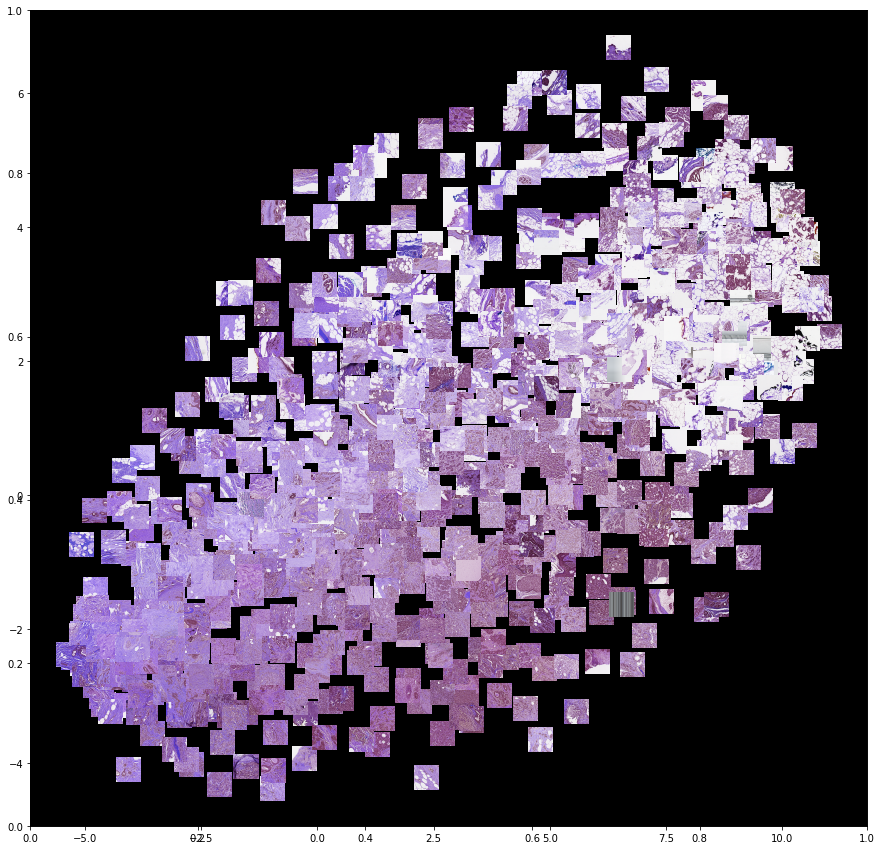

In [105]:
computeTSNEProjectionOfLatentSpace(train_x[:1000,], X_encoded_flatten[:1000,], display=True)

In [36]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_encoded_flatten[:1000,])


In [108]:
import pandas as pd
df = pd.DataFrame()
df['y'] = train_y_label[:1000]
df['comp-1'] = X_tsne[:,0]
df['comp-2'] = X_tsne[:,1]

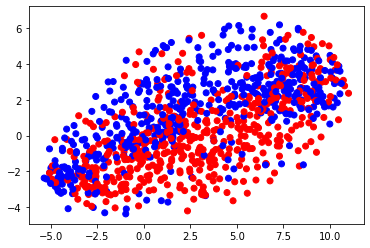

In [109]:
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df["comp-1"], df["comp-2"], c=df['y'].map(colors)) 